<a href="https://colab.research.google.com/github/wannasmile/colab_code_note/blob/main/MLID003.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Focal Loss

In [1]:
from sklearn import preprocessing
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import recall_score,accuracy_score,confusion_matrix,roc_auc_score
import numpy as np

绘制混淆矩阵

In [2]:
import itertools
import matplotlib.pyplot as plt
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.3f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [3]:
X, y = make_classification(n_classes=3,
                           n_samples=30000,
                           n_features=2,
                           n_informative=2,
                           n_redundant=0,
                           n_clusters_per_class=1,
                           weights=[.01, .01, .98],
                           flip_y=.01,
                           random_state=42)

le = preprocessing.LabelEncoder()
y_label = le.fit_transform(y)
X_train, X_test, y_train, y_test = train_test_split(X, y_label, test_size=0.30, random_state=42)

In [4]:
classes =[]
labeles=np.unique(y_label)
for v in labeles:
    classes.append('Class '+ str(v))
print(classes)

['Class 0', 'Class 1', 'Class 2']


Multiclass Lightgbm

In [5]:
import lightgbm as lgb
clf = lgb.LGBMClassifier()
clf.fit(X_train, y_train)
#clf.fit(X_train, y_train, verbose=0)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000739 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 21000, number of used features: 2
[LightGBM] [Info] Start training from score -4.313923
[LightGBM] [Info] Start training from score -4.303303
[LightGBM] [Info] Start training from score -0.027273


LGBMClassifier()

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000503 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 21000, number of used features: 2
[LightGBM] [Info] Start training from score -4.313923
[LightGBM] [Info] Start training from score -4.303303
[LightGBM] [Info] Start training from score -0.027273
Prediction accuracy 0.9832222222222222  recall  0.6360911470852438
Normalized confusion matrix
[[0.62295082 0.00819672 0.36885246]
 [0.00900901 0.28828829 0.7027027 ]
 [0.00148283 0.00148283 0.99703433]]


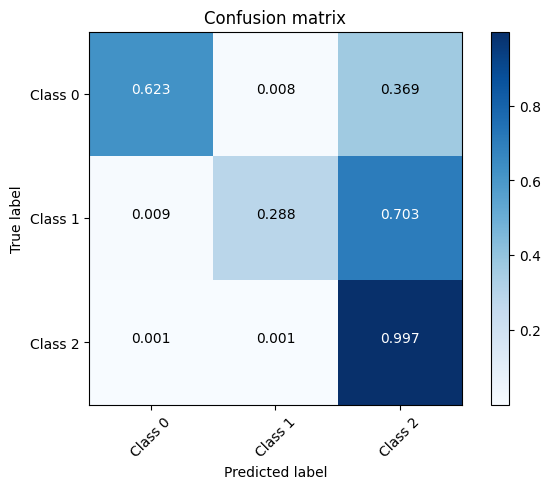

In [6]:
clf = lgb.LGBMClassifier()
clf.fit(X_train, y_train)

y_test_pred = clf.predict(X_test)
pred_accuracy_score = accuracy_score(y_test, y_test_pred)
pred_recall_score = recall_score(y_test, y_test_pred, average='macro')
print('Prediction accuracy', pred_accuracy_score,' recall ', pred_recall_score)

cnf_matrix = confusion_matrix(y_test, y_test_pred, labels=labeles)
plot_confusion_matrix(cnf_matrix, classes=classes, normalize=True, title='Confusion matrix')

Multiclass Lightgbm with Focal Loss

In [7]:
import numpy as np
from scipy import optimize
from scipy import special

class FocalLoss:

    def __init__(self, gamma, alpha=None):
        self.alpha = alpha
        self.gamma = gamma

    def at(self, y):
        if self.alpha is None:
            return np.ones_like(y)
        return np.where(y, self.alpha, 1 - self.alpha)

    def pt(self, y, p):
        p = np.clip(p, 1e-15, 1 - 1e-15)
        return np.where(y, p, 1 - p)

    def __call__(self, y_true, y_pred):
        at = self.at(y_true)
        pt = self.pt(y_true, y_pred)
        return -at * (1 - pt) ** self.gamma * np.log(pt)

    def grad(self, y_true, y_pred):
        y = 2 * y_true - 1  # {0, 1} -> {-1, 1}
        at = self.at(y_true)
        pt = self.pt(y_true, y_pred)
        g = self.gamma
        return at * y * (1 - pt) ** g * (g * pt * np.log(pt) + pt - 1)

    def hess(self, y_true, y_pred):
        y = 2 * y_true - 1  # {0, 1} -> {-1, 1}
        at = self.at(y_true)
        pt = self.pt(y_true, y_pred)
        g = self.gamma

        u = at * y * (1 - pt) ** g
        du = -at * y * g * (1 - pt) ** (g - 1)
        v = g * pt * np.log(pt) + pt - 1
        dv = g * np.log(pt) + g + 1

        return (du * v + u * dv) * y * (pt * (1 - pt))

    def init_score(self, y_true):
        res = optimize.minimize_scalar(
            lambda p: self(y_true, p).sum(),
            bounds=(0, 1),
            method='bounded'
        )
        p = res.x
        log_odds = np.log(p / (1 - p))
        return log_odds

    def lgb_obj(self, preds, train_data):
        y = train_data.get_label()
        p = special.expit(preds)
        return self.grad(y, p), self.hess(y, p)

    def lgb_eval(self, preds, train_data):
        y = train_data.get_label()
        p = special.expit(preds)
        is_higher_better = False
        return 'focal_loss', self(y, p).mean(), is_higher_better

In [8]:
import numpy as np
from joblib import Parallel, delayed
from sklearn.multiclass import _ConstantPredictor
from sklearn.preprocessing import LabelBinarizer
from scipy import special
import lightgbm as lgb


class OneVsRestLightGBMWithCustomizedLoss:

    def __init__(self, loss, n_jobs=3):
        self.loss = loss
        self.n_jobs = n_jobs

    def fit(self, X, y, **fit_params):
        fit_params["objective"] = self.loss.lgb_obj

        self.label_binarizer_ = LabelBinarizer(sparse_output=True)
        Y = self.label_binarizer_.fit_transform(y)
        Y = Y.tocsc()
        self.classes_ = self.label_binarizer_.classes_
        columns = (col.toarray().ravel() for col in Y.T)
        if 'eval_set' in fit_params:
            # use eval_set for early stopping
            X_val, y_val = fit_params['eval_set'][0]
            Y_val = self.label_binarizer_.transform(y_val)
            Y_val = Y_val.tocsc()
            columns_val = (col.toarray().ravel() for col in Y_val.T)
            self.results_ = Parallel(n_jobs=self.n_jobs)(delayed(self._fit_binary)
                                                         (X, column, X_val, column_val, **fit_params) for
                                                         i, (column, column_val) in
                                                         enumerate(zip(columns, columns_val)))
        else:
            # eval set not available
            self.results_ = Parallel(n_jobs=self.n_jobs)(delayed(self._fit_binary)
                                                         (X, column, None, None, **fit_params) for i, column
                                                         in enumerate(columns))

        return self

    def _fit_binary(self, X, y, X_val, y_val, **fit_params):
        unique_y = np.unique(y)
        init_score_value = self.loss.init_score(y)
        if len(unique_y) == 1:
            estimator = _ConstantPredictor().fit(X, unique_y)
        else:
            fit = lgb.Dataset(X, y, init_score=np.full_like(y, init_score_value, dtype=float))
            if 'eval_set' in fit_params:
                val = lgb.Dataset(X_val, y_val, init_score=np.full_like(y_val, init_score_value, dtype=float),
                                  reference=fit)

                estimator = lgb.train(params=fit_params,
                                      train_set=fit,
                                      valid_sets=(fit, val),
                                      valid_names=('fit', 'val'),
                                      #early_stopping_rounds=10,
                                      #fobj=self.loss.lgb_obj,
                                      feval=self.loss.lgb_eval,)
                                      #verbose_eval=10)
            else:
                estimator = lgb.train(params=fit_params,
                                      train_set=fit,
                                      #fobj=self.loss.lgb_obj,
                                      feval=self.loss.lgb_eval,)
                                      #verbose_eval=10)

        return estimator, init_score_value

    def predict(self, X):

        n_samples = X.shape[0]
        maxima = np.empty(n_samples, dtype=float)
        maxima.fill(-np.inf)
        argmaxima = np.zeros(n_samples, dtype=int)

        for i, (e, init_score) in enumerate(self.results_):
            margins = e.predict(X, raw_score=True)
            prob = special.expit(margins + init_score)
            np.maximum(maxima, prob, out=maxima)
            argmaxima[maxima == prob] = i

        return argmaxima

    def predict_proba(self, X):
        y = np.zeros((X.shape[0], len(self.results_)))
        for i, (e, init_score) in enumerate(self.results_):
            margins = e.predict(X, raw_score=True)
            y[:, i] = special.expit(margins + init_score)
        y /= np.sum(y, axis=1)[:, np.newaxis]
        return y

prediction accuracy 0.9834444444444445  recall  0.6170368937713694
Normalized confusion matrix
[[5.73770492e-01 8.19672131e-03 4.18032787e-01]
 [9.00900901e-03 2.79279279e-01 7.11711712e-01]
 [1.02657694e-03 9.12512832e-04 9.98060910e-01]]


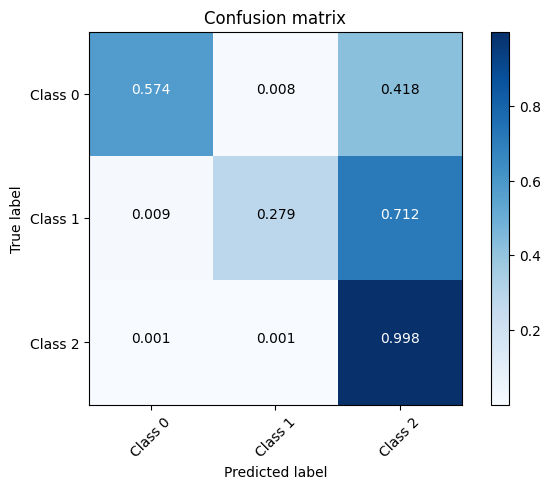

In [9]:
# Instantiate focal loss
loss = FocalLoss(alpha=0.75, gamma=2.0)

# Not using early stopping
clf = OneVsRestLightGBMWithCustomizedLoss(loss=loss)
clf.fit(X_train, y_train)

# Using early stopping
#fit_params = {'eval_set': [(X_test, y_test)]}
#clf.fit(X_train, y_train, **fit_params)

y_test_pred = clf.predict(X_test)
pred_accuracy_score = accuracy_score(y_test, y_test_pred)
pred_recall_score = recall_score(y_test, y_test_pred, average='macro')
print('prediction accuracy', pred_accuracy_score,' recall ', pred_recall_score)

cnf_matrix = confusion_matrix(y_test, y_test_pred, labels=labeles)
plot_confusion_matrix(cnf_matrix, classes=classes, normalize=True, title='Confusion matrix')

prediction accuracy 0.9841111111111112  recall  0.603252401501985
Normalized confusion matrix
[[5.49180328e-01 8.19672131e-03 4.42622951e-01]
 [9.00900901e-03 2.61261261e-01 7.29729730e-01]
 [4.56256416e-04 2.28128208e-04 9.99315615e-01]]


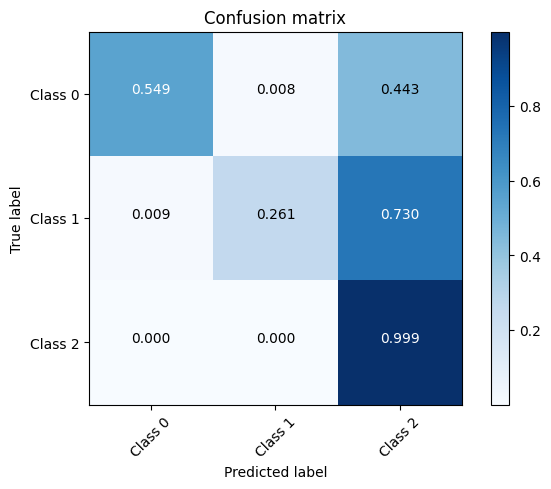

In [10]:
# Instantiate focal loss
loss = FocalLoss(alpha=0.75, gamma=2.0)

# Not using early stopping
#clf = OneVsRestLightGBMWithCustomizedLoss(loss=loss)
#clf.fit(X_train, y_train)

# Using early stopping
fit_params = {'eval_set': [(X_test, y_test)], 'early_stopping_rounds': 10}
clf.fit(X_train, y_train, **fit_params)

y_test_pred = clf.predict(X_test)
pred_accuracy_score = accuracy_score(y_test, y_test_pred)
pred_recall_score = recall_score(y_test, y_test_pred, average='macro')
print('prediction accuracy', pred_accuracy_score,' recall ', pred_recall_score)

cnf_matrix = confusion_matrix(y_test, y_test_pred, labels=labeles)
plot_confusion_matrix(cnf_matrix, classes=classes, normalize=True, title='Confusion matrix')

(9000,)
(9000, 3)
(9000, 3)


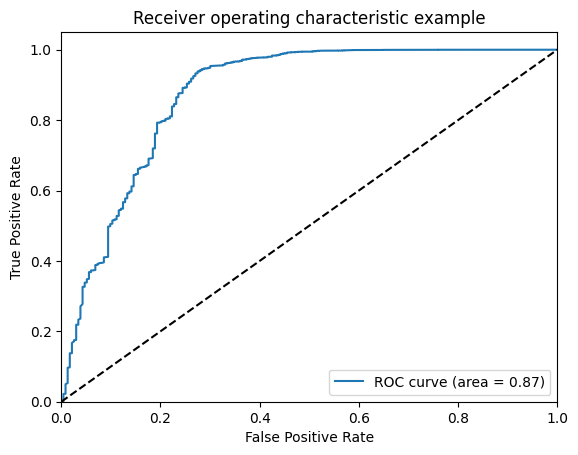

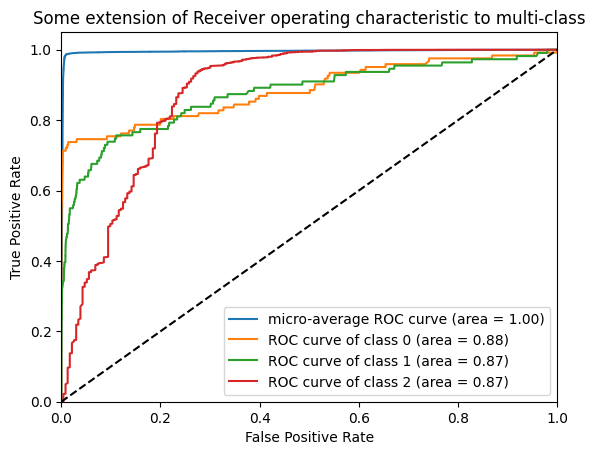

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier

y_test_score = clf.predict_proba(X_test)
print(y_test.shape)
print(y_test_score.shape)

# Binarize the output
y_test_label = label_binarize(y_test, classes=[0, 1, 2])
print(y_test_label.shape)
n_classes = y_test_label.shape[1]

#n_classes = len(classes)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_label[:, i], y_test_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_label.ravel(), y_test_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Plot of a ROC curve for a specific class
plt.figure()
plt.plot(fpr[2], tpr[2], label='ROC curve (area = %0.2f)' % roc_auc[2])
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

# Plot ROC curve
plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]))

for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'
                                   ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()